In [14]:
import cv2

import matplotlib.pyplot as plt

import numpy as np

from skimage.filters import threshold_otsu
from skimage.io import imread
from skimage.morphology import skeletonize

from sklearn.neighbors import NearestNeighbors
import networkx as nx

%matplotlib inline

In [15]:
# LOAD IMAGE AND OBTAIN VECTOR POINTS

image = imread('E:/University Work/Research/DocEng Book Series/Code Examples/Test1.png', as_gray=True).astype(np.uint8)

# binarise the image using Otsu's method
thresh = threshold_otsu(image)
binary = image > thresh

# obtain the image skeleteon using Lee's method based on the medial axis
skeleton = skeletonize(1 - binary, method='lee')

# obtain the list of vector points
P = np.where(skeleton == [1])

In [16]:
# SORT THE POINT LIST IN THE ORDER

# rearrange the points in an [N, 2] array
points = np.c_[P[1], P[0]]

# create a nearest neighbour graph to connect each node to its two nearest neighbours
clf = NearestNeighbors(n_neighbors=2).fit(points)
G = clf.kneighbors_graph()

# construct a graph from the sparse matrix G
T = nx.from_scipy_sparse_matrix(G)

# get the best path order from all the possible paths
paths = [list(nx.dfs_preorder_nodes(T, i)) for i in range(len(points))]

# find the one that minimises the distances between the connections
mindist = np.inf
minidx = 0

for i in range(len(points)):
    p = paths[i]           # order of nodes
    ordered = points[p]    # ordered nodes
    # find cost of that order by the sum of euclidean distances between points (i) and (i+1)
    cost = (((ordered[:-1] - ordered[1:])**2).sum(1)).sum()
    if cost < mindist:
        mindist = cost
        minidx = i
        
opt_order = paths[minidx]

# get the x and y values
x = P[1][opt_order]
y = P[0][opt_order]

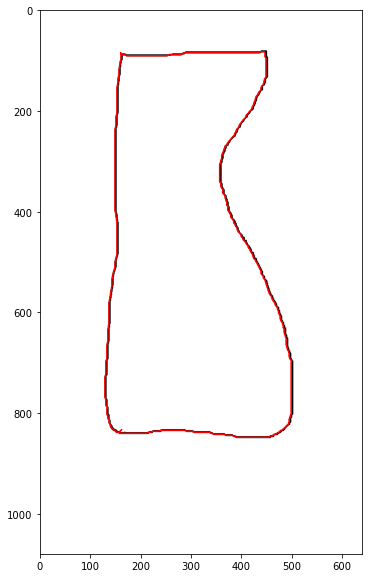

In [17]:
# PLOT THE IMAGE AND THE VECTOR POINTS

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111)
ax.imshow(image, cmap='gray')
plt.plot(x, y, color='red')


In [18]:
# PERFORM CRITICAL POINT DETECTION

# initialise a pointer
idx = []
idx.append(0)

# set the error tolerance
err = 5

# intialise the cone to accept all points for point inspected 
cone_min = -360
cone_max = 360

n = 1
while n < len(x):
    
        
    dx = x[n] - x[idx[-1]] # difference in x direction
    dy = y[n] - y[idx[-1]] # difference in y direction

    theta = np.arctan2(dy, dx)*180/np.pi; # angle of line between points
    
    
    if theta >= cone_min and theta <= cone_max: 
        
        # the point falls within the cone parameters
        
        dist = np.sqrt(dx ** 2 + dy ** 2) # the distance between the two points

        alpha = np.arctan2(err, dist)*180/np.pi # the extents at the new point
        
        # update the cone aperture
        cone_min = max([cone_min, theta - alpha])
        cone_max = min([cone_max, theta + alpha])
        
        
    else:
        
        #the point falls outside the cone parameters
        
        idx.append(n) # keep the point index
        
        # reset the cone
        cone_min = -360
        cone_max = 360

    # update index    
    n = n + 1

# append the first point to the list to close the loop
idx.append(idx[0])


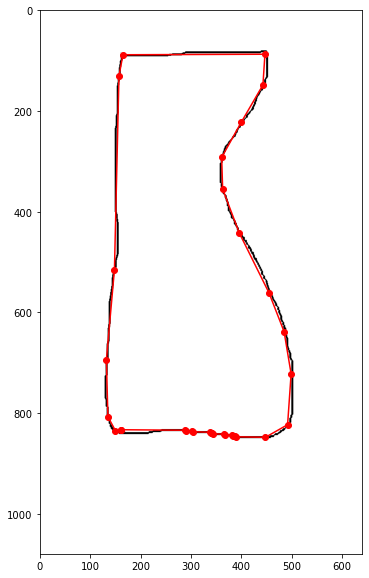

In [19]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111)
ax.imshow(image, cmap='gray')
plt.plot(x[idx], y[idx], 'r-o')
